In [ ]:
#connect with drive
from google.colab import auth
auth.authenticate_user()
from google.colab import drive
drive.mount('/content/drive')

#import packages and functions
!pip install pyspark
!pip3 install catboost
!pip install imbalanced-learn


import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta,date
import functools as ft
import pickle

#Spark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import random
from pyspark.sql.functions import col
from pyspark.sql.types import StringType,BooleanType,DateType, StructType
from pyspark.sql.functions import split
from pyspark.sql.functions import *
from pyspark.sql.functions import window
from pyspark.sql.window import Window

#For modelling
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
from catboost import CatBoostClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler


Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 37 kB/s 
     |████████████████████████████████| 199 kB 63.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=9f0f072ccece7fa3e9c3d959f7163f8f2b8f4067c00e8fb387ba222833dd8d19
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 28 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_pickle('/content/drive/My Drive/capstone 2 pickle files/cleaned_file.pickle')

In [ ]:
#Drop unimportant columns (sample columns)
df.drop(['hits_array_latencyTracking_speedMetricsSample','hits_array_latencyTracking_pageLoadSample','hits_array_latencyTracking_domLatencyMetricsSample','customDimensions_array_index'],axis = 1, inplace = True)

In [ ]:
object_cols = df.select_dtypes(include = ['object']).columns.to_list()
num_cols = df.select_dtypes(include = ['number']).columns.to_list()

In [ ]:
#fill NaN values in num columns with 0. Fill NaN values for object columns after converting dataframe to Spark
df.loc[:, num_cols] = df[num_cols].fillna(0)

In [ ]:
#Change date column to datetime type
df['date'] = pd.to_datetime(df['date'])
#Convert transaction value to $
df['totals_totalTransactionRevenue'] = df['totals_totalTransactionRevenue']/10**6

In [ ]:
#Convert df to parquet to read in spark
with open('/content/drive/My Drive/capstone 2 pickle files/df.parquet', 'wb') as f:
  df.to_parquet(f)

In [ ]:
spark = SparkSession\
.builder\
.appName('Project2')\
.master("local[*]")\
.config("spark.executor.memory", "70g")\
.config("spark.driver.memory", "50g")\
.config("spark.memory.offHeap.enabled",True)\
.config("spark.memory.offHeap.size","16g")\
.appName("sampleCodeForReference")\
.getOrCreate()

In [ ]:
df_sp = spark.read.parquet('/content/drive/My Drive/capstone 2 pickle files/df.parquet') 

In [ ]:
#Create new features
df_sp = df_sp\
        .withColumn("date_long", unix_timestamp('date', 'yyyy-MM-dd'))
days = lambda i: i * 86400 
w7 = (Window.partitionBy('fullVisitorId').orderBy("date_long").rangeBetween(-days(7),0))
w15 = (Window.partitionBy('fullVisitorId').orderBy("date_long").rangeBetween(-days(15),0))
w30 = (Window.partitionBy('fullVisitorId').orderBy("date_long").rangeBetween(-days(30),0))
churn_30 = (Window.partitionBy('fullVisitorId').orderBy("date_long").rangeBetween(days(1), days(30)))
churn_15 = (Window.partitionBy('fullVisitorId').orderBy("date_long").rangeBetween(days(1), days(15)))
churn_7 = (Window.partitionBy('fullVisitorId').orderBy("date_long").rangeBetween(days(1), days(7)))

wf = (Window.partitionBy('fullVisitorId').orderBy("date_long"))
wa = (Window.partitionBy('channelGrouping').orderBy("date_long").rangeBetween(-days(15),0))
wd = (Window.partitionBy('channelGrouping','date_long'))

df_sp = df_sp\
        .withColumn('7_day_visit', F.size(F.collect_set("visitNumber").over(w7)))\
        .withColumn('15_day_visit', F.size(F.collect_set("visitNumber").over(w15)))\
        .withColumn('30_day_visit', F.size(F.collect_set("visitNumber").over(w30)))\
        .withColumn('has_sales', F.when(F.col("totals_totalTransactionRevenue") > 0, F.col("visitNumber")).otherwise(None))\
        .withColumn('7_day_purchase', F.approx_count_distinct("has_sales").over(w7))\
        .withColumn('15_day_purchase', F.approx_count_distinct("has_sales").over(w15))\
        .withColumn('30_day_purchase', F.approx_count_distinct("has_sales").over(w30))\
        .withColumn('7_day_timeOnSite', F.sum("totals_timeOnSite").over(w7))\
        .withColumn('15_day_timeOnSite', F.sum("totals_timeOnSite").over(w15))\
        .withColumn('30_day_timeOnSite', F.sum("totals_timeOnSite").over(w30))\
        .withColumn('7_day_hits', F.sum("totals_hits").over(w7))\
        .withColumn('15_day_hits', F.sum("totals_hits").over(w15))\
        .withColumn('30_day_hits', F.sum("totals_hits").over(w30))\
        .withColumn('7_day_pageviews', F.sum("totals_pageviews").over(w7))\
        .withColumn('15_day_pageviews', F.sum("totals_pageviews").over(w15))\
        .withColumn('30_day_pageviews', F.sum("totals_pageviews").over(w30))\
        .withColumn('30_day_later', F.approx_count_distinct("visitId").over(churn_30))\
        .withColumn('churn30', F.when(F.col("30_day_later") == 0, 1).otherwise(0))\
        .withColumn('15_day_later', F.approx_count_distinct("visitId").over(churn_15))\
        .withColumn('churn15', F.when(F.col("15_day_later") == 0, 1).otherwise(0))\
        .withColumn('7_day_later', F.approx_count_distinct("visitId").over(churn_7))\
        .withColumn('churn7', F.when(F.col("7_day_later") == 0, 1).otherwise(0))\
        .withColumn('notChurn30', 1-F.col('churn30'))\
        .withColumn('bounce_7', F.size(F.collect_set("visitNumber").over(w7)))\
        .withColumn('7_day_visit', F.size(F.collect_set("visitNumber").over(w7)))\
        .withColumn('bounce_rate_7', F.col('bounce_7')/F.col('7_day_visit'))\
        .withColumn('bounce_15', F.size(F.collect_set("visitNumber").over(w15)))\
        .withColumn('15_day_visit', F.size(F.collect_set("visitNumber").over(w15)))\
        .withColumn('bounce_rate_15', F.col('bounce_15')/F.col('15_day_visit'))\
        .withColumn('bounce_30', F.size(F.collect_set("visitNumber").over(w30)))\
        .withColumn('30_day_visit', F.size(F.collect_set("visitNumber").over(w30)))\
        .withColumn('bounce_rate_30', F.col('bounce_30')/F.col('30_day_visit'))\
        .withColumn('first_visit', F.min('date_long').over(wf))\
        .withColumn('days_from_first_visit', (F.col('date_long') - F.col('first_visit'))/86400)\
        .withColumn('last_visit', lag('date_long',1).over(wf))\
        .withColumn('days_from_last_visit', (F.col('date_long') - F.col('last_visit'))/86400)\
        .withColumn('channel_avg_15', (F.size(F.collect_set("fullVisitorId").over(wa)))/15)\
        .withColumn('current_date_visits_by_channel', F.size(F.collect_set("fullVisitorId").over(wd)))\
        .withColumn('vs_channel_avg_15', F.col('current_date_visits_by_channel')/F.col("channel_avg_15")-1)\
        .withColumn('acceleration', F.col('15_day_visit')/F.col('30_day_visit'))\
        .drop('30_day_later')\
        .drop('has_sales')\
        .drop('date_long')
df_sp.show()

+-----------+----------+--------------+-------------------+-------------------+---------------+--------------------+------+--------------------+---------------+---------------+-----------------+------------------------+---------------------+-----------------+--------------------+---------------+---------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+-------------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------------------+------------------------------------------------+------------------------------------------------+------------------------------------------------+---------------------------------------+-------------------------------------------+-------------------------------

In [ ]:
#Merge additional columns with the original dataframe
cols = ['fullVisitorId','date','7_day_visit','15_day_visit','30_day_visit',\
        '7_day_purchase','15_day_purchase','30_day_purchase','7_day_timeOnSite',\
        '15_day_timeOnSite','30_day_timeOnSite','7_day_hits','15_day_hits',\
        '30_day_hits','7_day_pageviews','15_day_pageviews','30_day_pageviews',\
        'bounce_7','notChurn30','churn30','bounce_rate_7','bounce_15',\
        'bounce_rate_15','bounce_30','bounce_rate_30',\
        'days_from_first_visit','days_from_last_visit','channel_avg_15',\
        'current_date_visits_by_channel','acceleration','vs_channel_avg_15','churn15','churn7']
df2 = df_sp.select(cols)

In [ ]:
df3 = df2.toPandas()
df3 = df3.drop_duplicates()
df3['date'] = pd.to_datetime(df3['date'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df4 = pd.merge(df, df3, on = ['fullVisitorId','date'], how = 'left')
df4 = df4[(df4['date']>'2016-09-01') & (df4['date']<'2017-07-01')]

#EDA

1) Define churn 

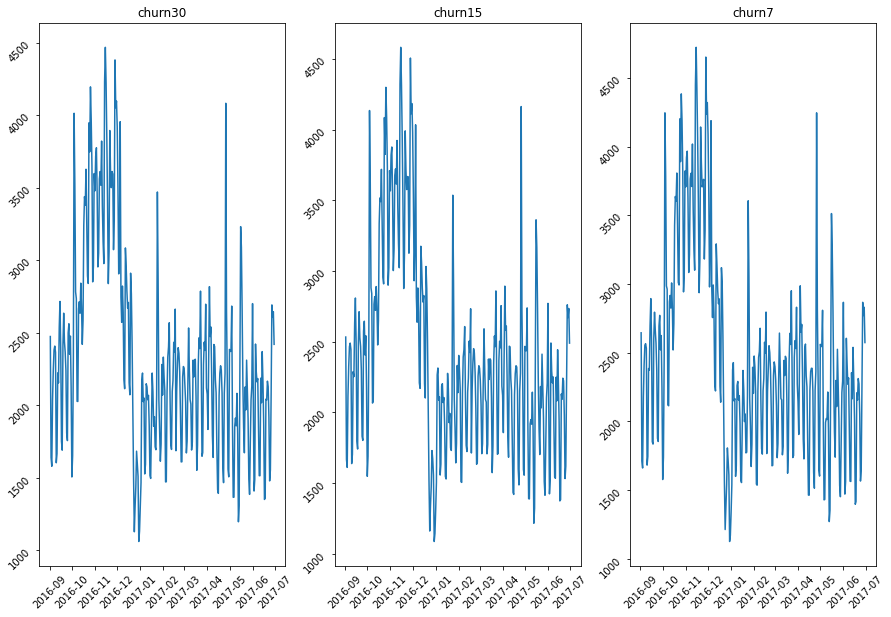

In [ ]:
df_plot = df4[['date','churn30','churn15','churn7']]
df_plot = df_plot.groupby('date').sum().reset_index()
df_plot.columns = ['date','churn30','churn15','churn7']


fig, axis = plt.subplots(1, 3)
fig.set_figheight(10)
fig.set_figwidth(15)
axis[0].plot(df_plot['date'],df_plot['churn30'])
axis[0].set_title("churn30")
axis[0].tick_params(labelrotation=45)
axis[1].plot(df_plot['date'],df_plot['churn15'])
axis[1].set_title("churn15")
axis[1].tick_params(labelrotation=45)
axis[2].plot(df_plot['date'],df_plot['churn7'])
axis[2].set_title("churn7")
axis[2].tick_params(labelrotation=45)


Since all 3 metrics follow the same trend, we will define churn mainly based on business consideration. 7 days and 15 days are generally too short to expect customers to come back, especially for non-essential products. Therefore, we will go with 30 days timeframe 

2) Churned vs. Not Churned distribution 

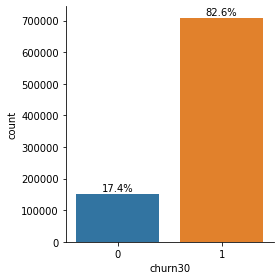

In [ ]:
g = sns.catplot(x='churn30', data=df4, kind='count', height=4, aspect=1)
# Get current axis on current figure
ax = plt.gca()
# Iterate through the list of axes' patches
total = len(df4.churn30)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

The dataset is imbalance: 17.4% not churned and 82.6% churned

3) Churned vs. Not Churned distribution by channels 

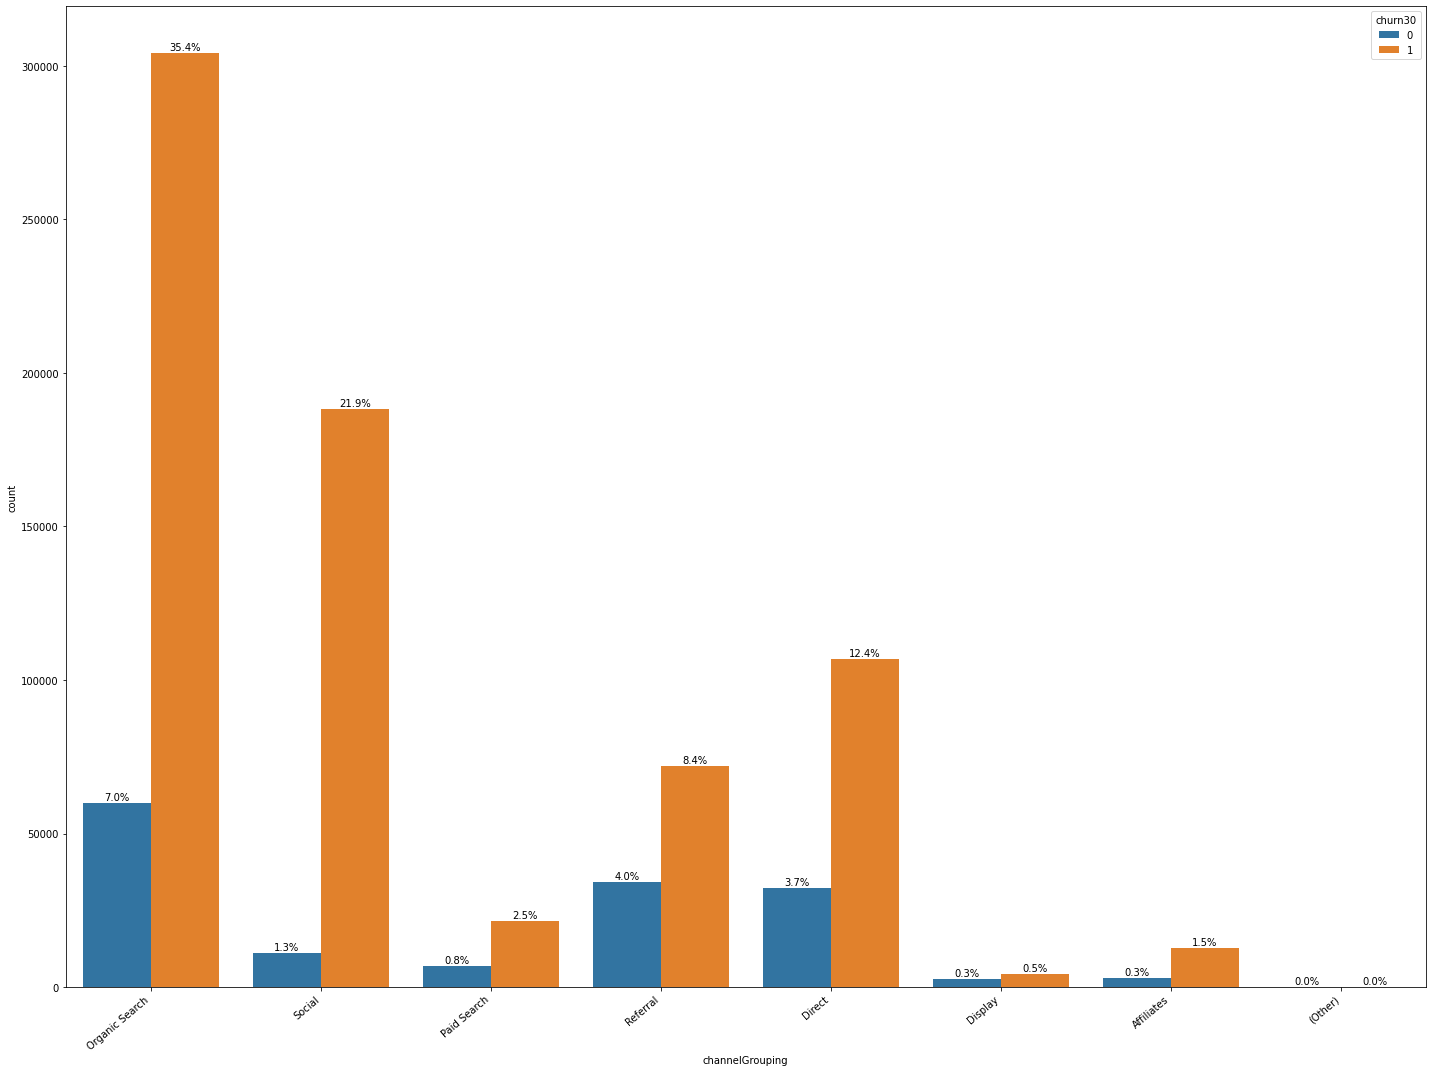

In [ ]:
plt.figure(figsize=(20, 15))
ax = sns.countplot(x='channelGrouping', data=df4,  hue = 'churn30')
# Get current axis on current figure
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# Iterate through the list of axes' patches
total = len(df4.churn30)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center')
plt.tight_layout()
plt.show()

Display, referral, and paid have the highest not churned:churned ratios (60%, 47.6%, 32%), whereas social has the lowest one (5.9%) 

#Calculate IV for categorical variables

In [ ]:
#Fill null values for object columns
df4.loc[:, object_cols] = df4[object_cols].fillna(' ')
df4.loc[:,'days_from_last_visit']= df4['days_from_last_visit'].fillna(0)

In [ ]:
continuous, categorical, single, multiple = [], [], [], []
#Remove columns that shouldn't matter to the target variable 
black_list = ['notChurn30', 'ym', 'date', 'fullVisitorId',\
              'visitId','visitStartTime','hits_array_minute','hits_array_hour',\
              'hits_array_time','hits_array_item_transactionId','hits_array_transaction_transactionId']
#There are only 4 values for transactions but these features should be continuous
transaction = ['hits_array_transaction_transactionRevenue',\
 'hits_array_transaction_transactionTax',\
 'hits_array_transaction_transactionShipping',\
 'hits_array_transaction_localTransactionRevenue',\
 'hits_array_transaction_localTransactionTax',\
 'hits_array_transaction_localTransactionShipping',\
 'hits_array_product_array_productRevenue',\
 'hits_array_product_array_localProductRevenue','totals_transactions',\
 '7_day_purchase',
 '15_day_purchase',
 '30_day_purchase']
for col in [c for c in df4.columns if c not in black_list and c != 'churn30']:
    if col in transaction:
      continuous.append(col)
    elif ((df4[col].nunique() > 1) & (df4[col].nunique() < 20)):
      categorical.append(col)
    elif (df4[col].nunique() == 1):
      single.append(col)
    elif is_numeric_dtype(df4[col]):
        continuous.append(col)     
    else:
      multiple.append(col)


In [ ]:
#check if any class in any categorical column doesn't contain both good and bad targets 
check = []
for col in categorical:
  dff = df4.groupby(col).agg({'churn30':'sum', 'notChurn30':'sum'}).reset_index()
  result = (dff[['churn30', 'notChurn30']] == 0).any().any()
  check.append((col,result))

allchurn = []
for i in range(len(check)):
  x, y = check[i]
  if y == True:
    allchurn.append(x)
#columns with categories that don't contain both good and bad classes
allchurn

['hits_array_social_socialNetwork',
 'hits_array_eCommerceAction_step',
 'hits_array_eCommerceAction_option',
 'hits_array_page_searchKeyword',
 'trafficSource_campaign',
 'trafficSource_adwordsClickInfo_page',
 'hits_array_promotion_array_promoId',
 'hits_array_promotion_array_promoName',
 'hits_array_promotion_array_promoCreative',
 'hits_array_promotion_array_promoPosition',
 'hits_array_product_array_productVariant',
 'hits_array_product_array_productBrand',
 'hits_array_product_array_productListName',
 'churn15',
 'churn7']

In [ ]:
for i in allchurn:
  print(df4.groupby(i).agg({'churn30':'sum','notChurn30':'sum'}))

                                 churn30  notChurn30
hits_array_social_socialNetwork                     
(not set)                         521127      138742
Digg                                   1           0
Facebook                            4940        1072
Google Groups                        825         339
Google+                              386         192
LinkedIn                              20           0
Meetup                                 1           0
Pinterest                             29           7
Pocket                                14           0
Quora                               1707          99
Tumblr                                 2           0
Twitter                             1486         163
VKontakte                             92          25
YouTube                           176752        8905
reddit                              1940         338
                                 churn30  notChurn30
hits_array_eCommerceAction_step               

In [ ]:
#Remove trafficSource_campaignCode

#Group values that have 0 notChurn30 or 0 churn30 with suitable values (usually the most dominant one) 
df4['hits_array_social_socialNetwork'] = df4.hits_array_social_socialNetwork.replace(['Digg','Hacker News','LinkedIn','Meetup','Pocket','Tumblr'],'(not set)')
df4['hits_array_eCommerceAction_step'] = df4.hits_array_eCommerceAction_step.replace([3],1)
df4['hits_array_eCommerceAction_option'] = df4.hits_array_eCommerceAction_option.replace(['Review'],' ')
df4['hits_array_page_searchKeyword'] = df4.hits_array_page_searchKeyword.replace(['hoodie','jersey','mug','speakers','stickers','sticker'],' ')
df4['trafficSource_campaign'] = df4.trafficSource_campaign.replace(['All Products','Data Share'],'(not set)')
df4['trafficSource_adwordsClickInfo_page'] = df4.trafficSource_adwordsClickInfo_page.replace([3,7,9,14],0)
df4['hits_array_promotion_array_promoId'] = df4.hits_array_promotion_array_promoId.replace('Lifestyle_HomeBanner_TopSlot_1',' ')
df4['hits_array_promotion_array_promoName'] = df4.hits_array_promotion_array_promoName.replace('Lifestyle Campaign',' ')
df4['hits_array_promotion_array_promoCreative'] = df4.hits_array_promotion_array_promoCreative.replace('HomepageLifestyle2016Sam.jpg',' ')
df4['hits_array_promotion_array_promoPosition'] = df4.hits_array_promotion_array_promoPosition.replace('HomeBanner_TopSlot_1',' ')
df4['hits_array_product_array_productVariant'] = df4.hits_array_product_array_productVariant.replace(['(not set)',' XL',' BLACK',' 2T'],' ')
df4['hits_array_product_array_productBrand'] = df4.hits_array_product_array_productBrand.replace(['Go','(not set)'],' ')
df4['hits_array_product_array_productListName'] = df4.hits_array_product_array_productListName.replace(['Mens Outerwear','Fun','(not set)'],' ')

In [ ]:
def calc_iv(df, feature, target):

    lst = []

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], df[(df[feature] == val) & (df[target] == 1)].count()[feature]])

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])
    data['Good'] = data['All'] - data['Bad']
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['Good']) / (data['Good'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data['IV'] = (data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])).sum()
    return data[['Variable','IV']].drop_duplicates().values.tolist()[0]
    
def combine(df, list_categorical, target):
    IV = []
    for feature in list_categorical:
      iv = calc_iv(df, feature, target)
      IV.append(iv)
      IV_df = pd.DataFrame(IV, columns = ['feature','IV'])
    return IV_df


In [ ]:
iv = combine(df4, categorical, 'churn30')

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


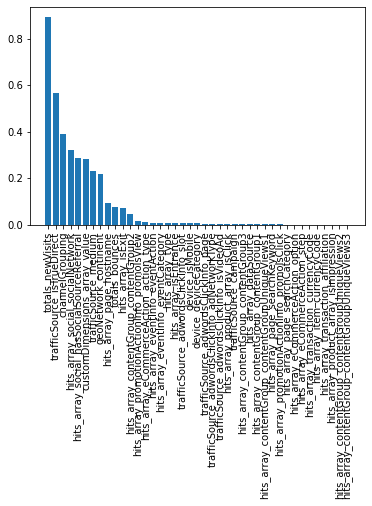

In [ ]:
plot_df = iv.sort_values('IV', ascending = False)[(iv['IV'] > 0)&(iv['IV'] <1)]
plt.bar(data = plot_df, x = 'feature', height = 'IV')
plt.xticks(rotation = 90)
plt.show();

In [ ]:
#Combine the high IV categorical features with the numerical features, then run random forest model to futher select the best features
selected_cat_cols = plot_df[plot_df['IV'] > 0.01].feature.to_list()
all_cols = selected_cat_cols + continuous +['fullVisitorId','churn30','date']

In [ ]:
df5 = df4[all_cols]
df5 = pd.get_dummies(df5, columns = selected_cat_cols, drop_first = True)

In [ ]:
X = df5.drop(['churn30','fullVisitorId','date'], axis = 1)
y = df5.churn30

In [ ]:
scaler = preprocessing.StandardScaler().fit(X)
X_scaled=scaler.transform(X)
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_scaled, y)

30


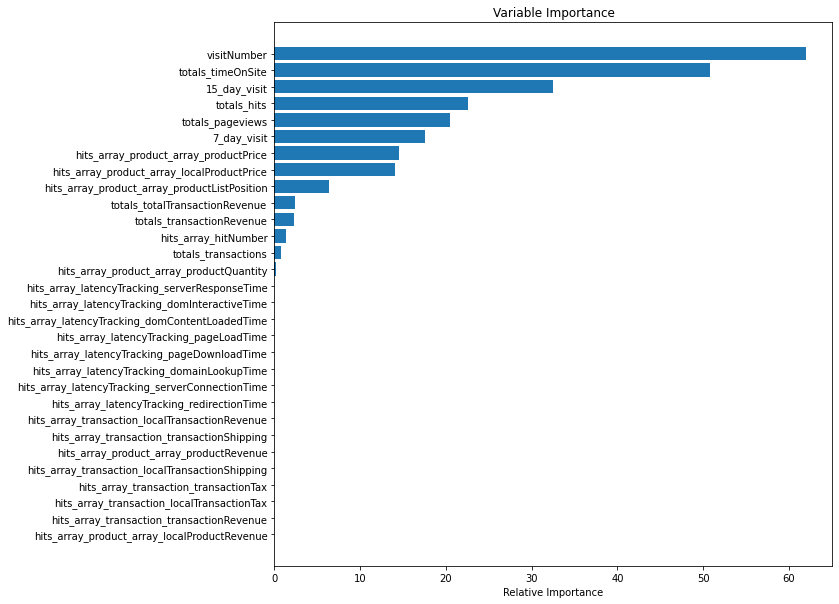

In [ ]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance_relative = (100.0 * feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance_relative)[:30]
pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance_relative[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
final_features = ['visitNumber','totals_timeOnSite','15_day_visit','7_day_visit','totals_hits','totals_pageviews','hits_array_product_array_productPrice',\
                  'hits_array_product_array_localProductPrice','hits_array_product_array_productListPosition','totals_transactionRevenue','totals_totalTransactionRevenue','hits_array_hitNumber','totals_transactions']
len(final_features)

13

In [ ]:
df_modeling = df5[final_features+['churn30','fullVisitorId','date']]
path = '/content/drive/My Drive/capstone 2 pickle files/df_modeling.pickle'
with open(path, 'wb') as f:
  pickle.dump(df_modeling, f)